# Model 18: The evolution of social learning

original: https://bookdown.org/amesoudi/ABMtutorial_bookdown/model18.html

## Introduction

- 遺伝子と文化の共進化 (Gene-culture coevolution) 
    - ここまでで、学習バイアスや人口統計学的プロセスによって、文化的特徴の人口頻度の変化によって、文化進化のメカニズムを研究してきた。
    - しかし、そもそもこの学習バイアス自体はどのように進化したのだろうか？
    - これは、遺伝子-文化共進化 (gene-culture coevolution) モデルであり、社会的学習バイアスを表す遺伝子の様なものがあり、その遺伝子が保有者に獲得させる文化的特質の適応的価値の結果として出現拡散すると仮定している。
- 最も基本的な問いは、なぜ/いかにして、個人的学習から社会的学習が進化したのか？である。
    - 個人的学習と比較して、社会的学習のコストとベネフィットは何か？
    - 一般的な答えとしては、個人的学習よりも社会的学習のほうが、コスト面で有利だということである。自分で環境から学習するよりも、他人の真似をした方が楽というのは理にかなっている。
- ロジャースのパラドックス
    - ロジャースのモデル (1988) は、社会的学習が個人的学習よりもコストが低い場合には確かに進化し、社会的学習者と個人的学習者が共存することを示した。
    - しかしこのモデルは同時に、社会的学習と個人的学習が共存している集団と、個人的学習しか存在しない集団の、集団全体での平均適応度が等しいことも示した。
    - これは、社会的学習 (すなわち文化) が、個体・集団・種にとって適応的であるという一般的な主張と矛盾している。これを「ロジャースのパラドックス」という。
    - Model 18a ではこのパラドックスを再現し、Model 18b では、その解決策を提示する。

## Model 18a: Rogers’ model

In [1]:
using JupyterFormatter
enable_autoformat()

using DataFrames
using StatsBase
using Plots
using Test: @test, @testset

println("Julia version: ", VERSION)

Julia version: 1.9.0


In [6]:
function make_agent_df(N::Int)::DataFrame
    DataFrame(learning = fill("IL", N), behaviour = fill(false, N), fitness = fill(0.0, N))
end

function make_output_df(time_steps::Int)::DataFrame
    DataFrame(
        SLfreq = fill(0.0, time_steps),
        SLfitness = fill(0.0, time_steps),
        ILfitness = fill(0.0, time_steps),
        predictedILfitness = fill(0.0, time_steps),
    )
end

function individual_learning!(agent_df::DataFrame, pᵢ::Float64)::Nothing
    weights = Weights([pᵢ, 1 - pᵢ])
    il_vec = agent_df.learning .== "IL"
    agent_df[il_vec, :behaviour] .= sample([true, false], weights, sum(il_vec))
    return
end

function social_learning!(agent_df::DataFrame, v::Float64)::Nothing
    sl_vec = agent_df.learning .== "SL"

    # if environment has changed, all social learners have incorrect beh
    if v < rand()
        agent_df[sl_vec, :behaviour] .= false
    else
        # otherwise for each social learner, pick a random demonstrator from previous timestep
        # if demonstrator is correct, adopt correct beh
        dem = sample(agent_df.behaviour, nrow(agent_df))
        agent_df[sl_vec.&&dem, :behaviour] .= true  # correct
        agent_df[sl_vec.&&.!dem, :behaviour] .= false  # incorrect
    end

    return
end

function update_fitnesses!(agent_df::DataFrame, b::Float64, cᵢ::Float64)::Nothing
    agent_df.fitness .= [behaviour ? 1 + b : 1 for behaviour in agent_df.behaviour]
    il_vec = agent_df.learning .== "IL"
    agent_df.fitness[il_vec] .= agent_df.fitness[il_vec] .- cᵢ
    return
end

function record_frequency_and_fitnesses!(
    output_df::DataFrame,
    agent_df::DataFrame,
    time_step::Int,
)::Nothing
    sl_vec = agent_df.learning .== "SL"
    output_df.SLfreq[time_step] = sum(sl_vec) / nrow(agent_df)
    output_df.SLfitness[time_step] = sum(sl_vec) > 0 ? mean(agent_df.fitness[sl_vec]) : 0
    output_df.ILfitness[time_step] = mean(agent_df.fitness[.!sl_vec])
    return
end

function selection_and_reproduction!(agent_df::DataFrame)::Nothing
    relative_fitness = agent_df.fitness ./ sum(agent_df.fitness)
    agent_df.learning .=
        sample(agent_df.learning, Weights(relative_fitness), nrow(agent_df))
    return
end

function mutation!(agent_df::DataFrame, μ::Float64)::Nothing
    mutation_rates = rand(nrow(agent_df)) .< μ
    il_vec = agent_df.learning .== "IL"
    agent_df.learning[il_vec.&&mutation_rates] .= "SL"
    agent_df.learning[.!il_vec.&&mutation_rates] .= "IL"
    return
end

function rogers_model(;
    N::Int = 10_000,
    time_steps::Int = 1_000,
    pᵢ::Float64 = 0.5,  # chance of discovering the correct behaviour
    b::Float64 = 1.0,
    cᵢ::Float64 = 0.2,
    μ::Float64 = 0.001,
    v::Float64 = 0.9,  # probability of changing environment
)::DataFrame
    agent_df = make_agent_df(N)
    output_df = make_output_df(time_steps)

    for time_step = 1:time_steps
        individual_learning!(agent_df, pᵢ)
        social_learning!(agent_df, v)
        update_fitnesses!(agent_df, b, cᵢ)
        record_frequency_and_fitnesses!(output_df, agent_df, time_step)
        selection_and_reproduction!(agent_df)
        mutation!(agent_df, μ)
    end

    output_df.predictedILfitness .= 1 + b * pᵢ - cᵢ

    return output_df
end

function plot_output(df::DataFrame)::Nothing
    p1 = plot(
        df.SLfreq,
        xlab = "generation",
        ylab = "proportion of social learners",
        lc = :orange,
        legend = false,
    )

    POPfitness = df.SLfreq .* df.SLfitness .+ (1 .- df.SLfreq) .* df.ILfitness

    p2 = plot(ylim = (0.5, 2), xlab = "generation", ylab = "mean fitness")
    plot!(df.SLfitness, lc = :orange, label = "social learners")
    plot!(df.ILfitness, lc = :royalblue, label = "individual learners")
    plot!(POPfitness, lc = :grey, label = "population")
    hline!([df.predictedILfitness[1]], ls = :dash, lc = :black, label = false)

    display(plot(p1, p2, size = (800, 450)))
end;

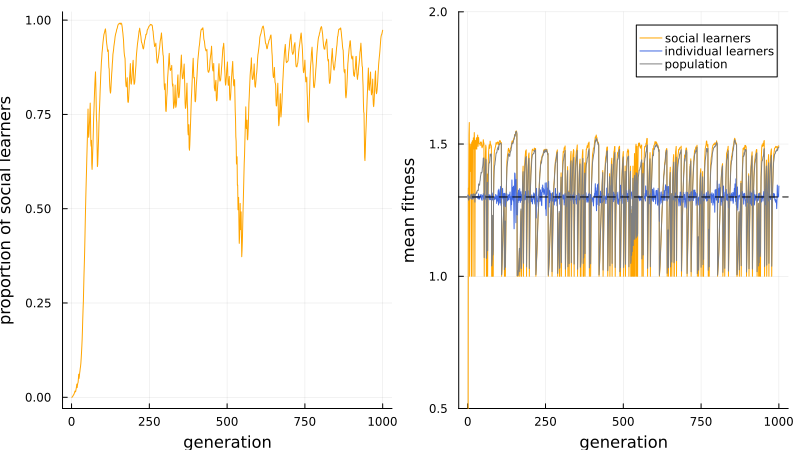

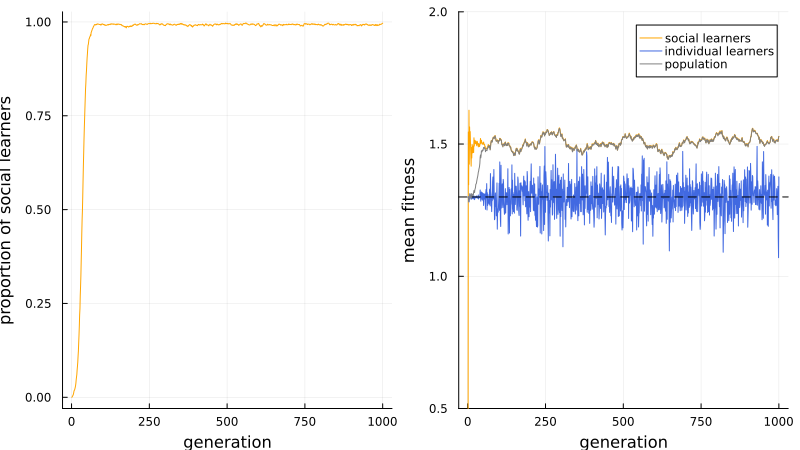

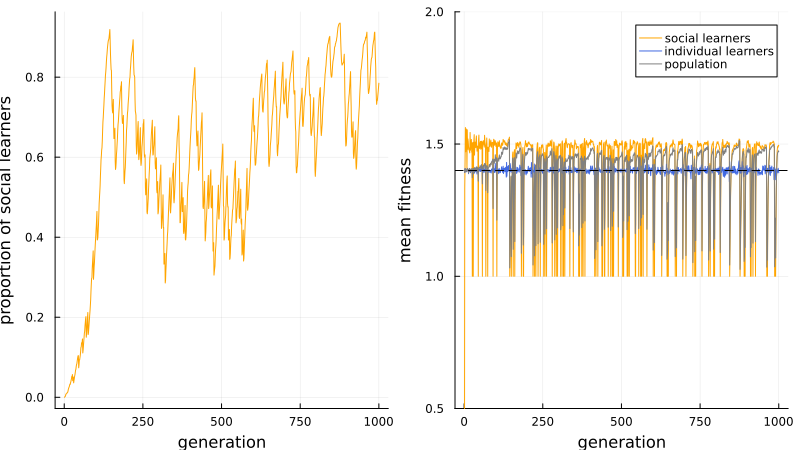

In [7]:
plot_output(rogers_model())
plot_output(rogers_model(v = 1.0))
plot_output(rogers_model(cᵢ = 0.1))

## Model 18b: Critical social learning

- Rogers' paradox
    - 個人的学習よりも社会的学習の方が低コストな場合、社会的学習が進化しうることを Rogers’ model は示したが、文化が適応的であるという主張に反して社会的学習は集団全体の平均適応度を増やさない。
    - 一つの解決策は、環境の変化をなくしてしまうことだが、それは現実に即していない。
    - もう一つの解決策は、エージェントが個人的学習か社会的学習のどちらか一方しかやらないという非現実的な前提を緩和することである。
        - 社会的学習は個人的学習に取って代わるのではなくそれを補完するものなのだ。
        - 実際、社会的学習は個人的学習と同じ学習メカニズムによって立っていることが分かっている (Heyes 2012)。
- Enquist et al. (2007) therefore proposed a third, more plausible strategy: a critical social learner.
    - These critical social learners learn socially first, and if the copied solution is incorrect, they then learn individually.
    - Model 18b adds critical social learners to the simulation to see whether they do better than pure social and pure individual learners, and whether they overcome Rogers’ paradox.
- The following function EnquistModel adapts RogersModel to include critical learners.
    - The parameters and their defaults are identical, as is the agent dataframe.
    - The output dataframe now tracks the frequency and mean fitness of critical learners (“CL”s) in addition to social and individual learners.
    - Individual learners individually learn as before, then both social and critical learners socially learn.
    - The major new block of code implements individual learning for the incorrect critical learners.
    - However, the actual code and fitness assignments are identical to those earlier in the function for individual learners, so there’s nothing new here.
    - The final difference is mutation, which now includes critical learners.

## Summary

## Analytical Appendix

In [4]:
length([1, 2])

2